# Split large clusters

In [1]:
!pip install shapely

In [11]:
import matplotlib.pyplot as plt
import pandas as pd
import pickle
import json
import numpy as np
from shapely.geometry import Point, Polygon
from utils.geo_plot import setup_ax, plot_locs

import importlib
#from preprocessing.create_folds import (
#    create_folds,
#    create_split_folds,
#    save_folds,
#    verify_folds)

import preprocessing.create_folds_b
importlib.reload(preprocessing.create_folds_b)

<module 'preprocessing.create_folds_b' from 'c:\\Users\\Benjamin\\Desktop\\Exjobb\\CreateFolds\\preprocessing\\create_folds_b.py'>

In [2]:
dhs_df = pd.read_csv('../dhs_clusters.csv', float_precision='high', index_col=False)
dhs_locs = dhs_df[['lat', 'lon']].values
FOLDS = ['A', 'B', 'C', 'D', 'E']
#MIN_DIST = 0.096198
deg_to_km = 111
km_to_deg = 1/deg_to_km
km_to_deg

radius = np.sqrt(km_to_deg**2 * 2)
radius = radius * 6.72
print(radius)
MIN_DIST = radius

with open('dhs_incountry_folds.pkl', 'rb') as f:
    dhs_incountry_folds = pickle.load(f)

0.0856172535058306


In [3]:
def plot_splits(locs_dict, title=None):
    '''
    Args
    - locs_dict: dict, label (str) => np.array of lat, lon
    '''
    fig = plt.figure(figsize=[15, 15])
    ax = setup_ax(fig)

    for label, locs_array in locs_dict.items():
        ax.scatter(locs_array[:, 1], locs_array[:, 0], label=label, s=2)

    lgd = ax.legend()
    for handle in lgd.legendHandles:
        handle.set_sizes([50.0])

    if title is not None:
        ax.set_title(title)
    plt.show()

Create in-country folds:

num clusters: 4422
num outliers: 7859
max cluster size (excl. outliers): 6711


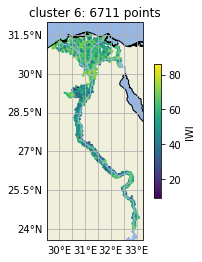

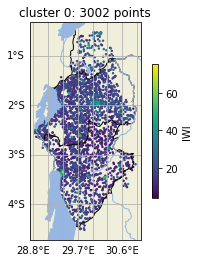

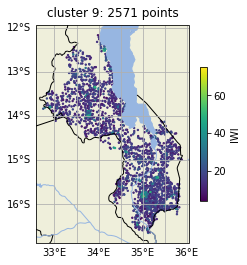

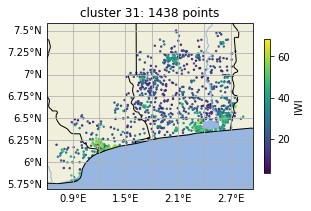

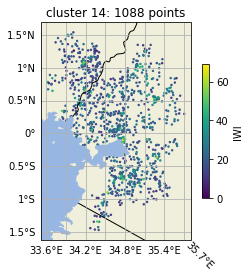

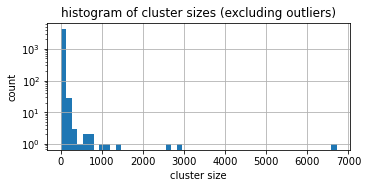

In [12]:
dhs_incountry_test_folds = preprocessing.create_folds_b.create_folds(
    df=dhs_df,
    #locs=dhs_locs,
    min_dist=MIN_DIST,
    fold_names=FOLDS,
    plot_largest_clusters=5)

#verify_folds(
#    folds=dhs_incountry_test_folds,
#    locs=dhs_locs,
#    min_dist=MIN_DIST,
#    max_index=len(dhs_locs))

dhs_incountry_folds = preprocessing.create_folds_b.create_split_folds(
    test_folds=dhs_incountry_test_folds,
    fold_names=FOLDS)

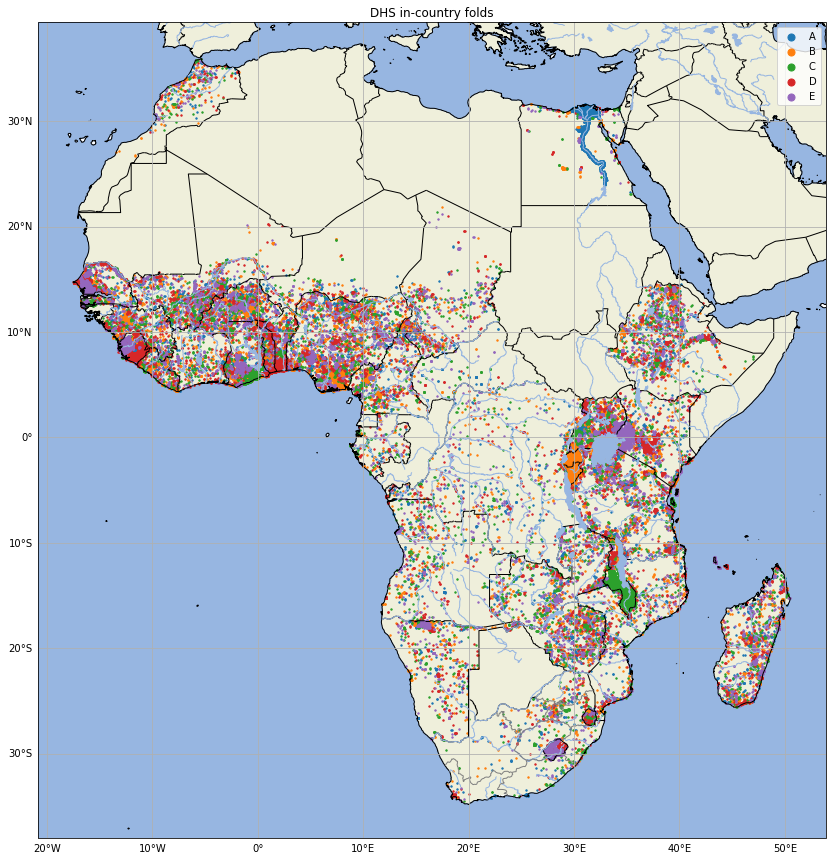

fold A - MEAN:  44.02450291625204 , STD DEV:  22.06711137171514
fold B - MEAN:  28.571310300798462 , STD DEV:  18.150788681989855
fold C - MEAN:  28.550789051566827 , STD DEV:  17.153039419140736
fold D - MEAN:  30.289527469235797 , STD DEV:  17.815079613265514
fold E - MEAN:  29.414674418946035 , STD DEV:  16.907889173799465


<Figure size 1600x800 with 0 Axes>

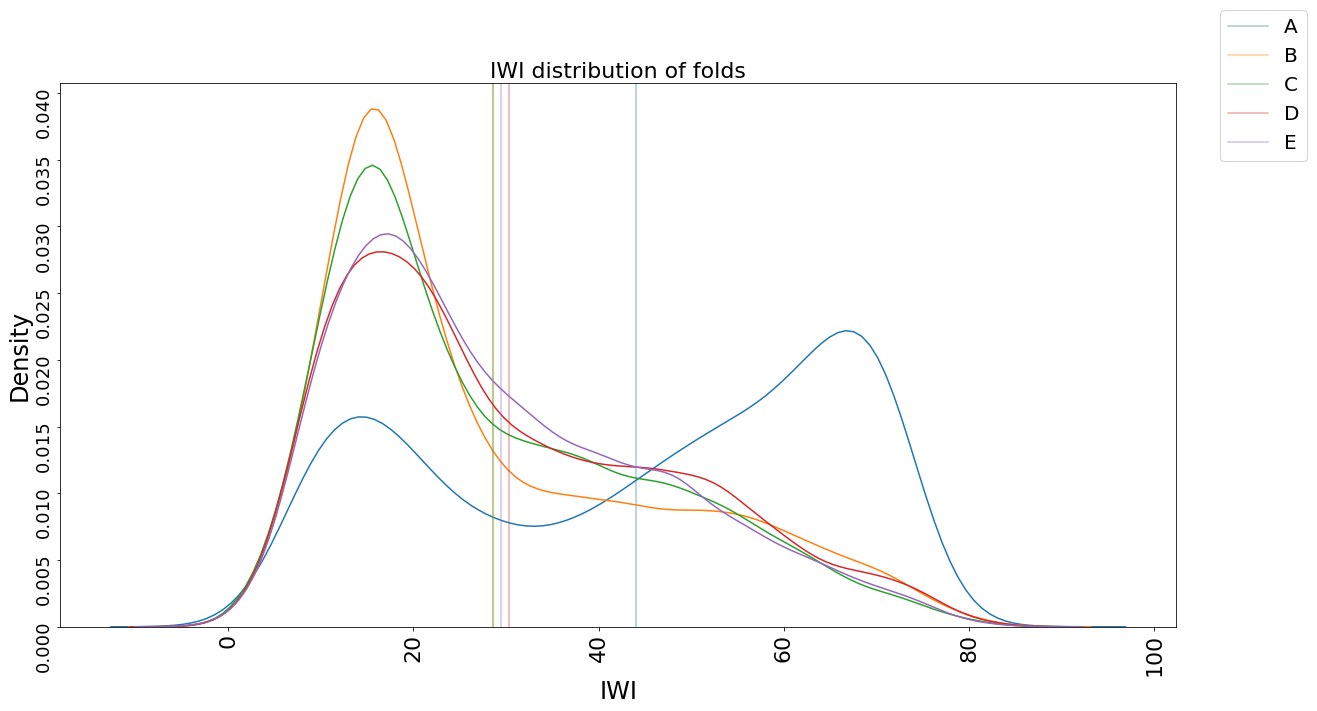

In [13]:
plot_splits({f: dhs_locs[dhs_incountry_folds[f]['test']] for f in FOLDS},
            title='DHS in-country folds')

plot_iwi_distribution(dhs_df, dhs_incountry_folds, 'IWI distribution of folds')

Read remove regions from geojson:

In [14]:
with open('remove_regions2.json') as f:
    remove_regions_gj = json.load(f)

remove_regions = []
for region in remove_regions_gj['features']:
  remove_regions.append(Polygon(region['geometry']['coordinates'][0]))

In [15]:
def in_polys(point, polys):
  for poly in polys:
    if point.within(poly):
      return True
  return False

dhs_df['geomtery'] = dhs_df.apply(lambda row: Point(row['lon'], row['lat']), axis=1)
new_dhs_df = dhs_df[~(dhs_df['geomtery'].apply(lambda p: in_polys(p, remove_regions)))]

In [16]:
importlib.reload(preprocessing.create_folds_b)

<module 'preprocessing.create_folds_b' from 'c:\\Users\\Benjamin\\Desktop\\Exjobb\\CreateFolds\\preprocessing\\create_folds_b.py'>

num clusters: 4433
num outliers: 7859
max cluster size (excl. outliers): 1963


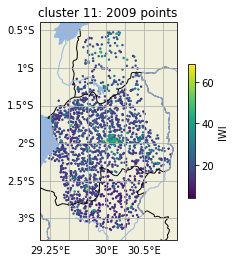

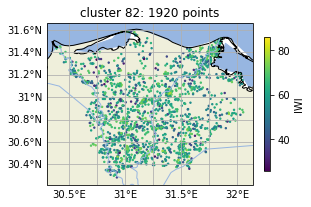

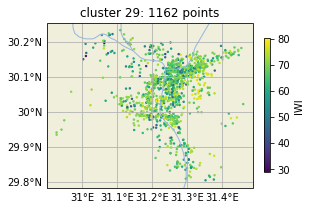

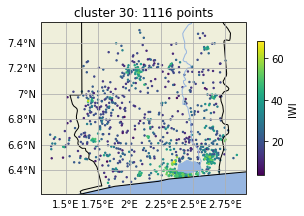

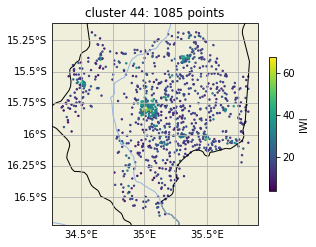

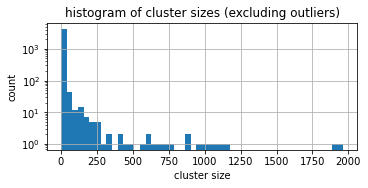

In [17]:
# Fraction: 100%, random_state = 1339, big_fold_penalty = 150
# Fraction: 10%, random_state = 1337, big_fold_penalty = 150
# Fraction: 50%, random_state = 1337, big_fold_penalty = 150
# Fraction: 1%, random_state = 1339, big_fold_penalty = 150
# Fraction: 25%, random_state = 1339, big_fold_penalty = 150

new_dhs_locs = new_dhs_df[['lat', 'lon']].values

new_dhs_incountry_test_folds = preprocessing.create_folds_b.create_folds(
    df=new_dhs_df,
    min_dist=MIN_DIST,
    fold_names=FOLDS,
    plot_largest_clusters=5,
    fraction=1,
    big_fold_penalty=150,
    random_state = 1339)

# preprocessing.create_folds_b.verify_folds(
#     folds=new_dhs_incountry_test_folds,
#     locs=new_dhs_locs,
#     min_dist=MIN_DIST,
#     max_index=np.max(new_dhs_df.index))

new_dhs_incountry_folds = preprocessing.create_folds_b.create_split_folds(
    test_folds=new_dhs_incountry_test_folds,
    fold_names=FOLDS)

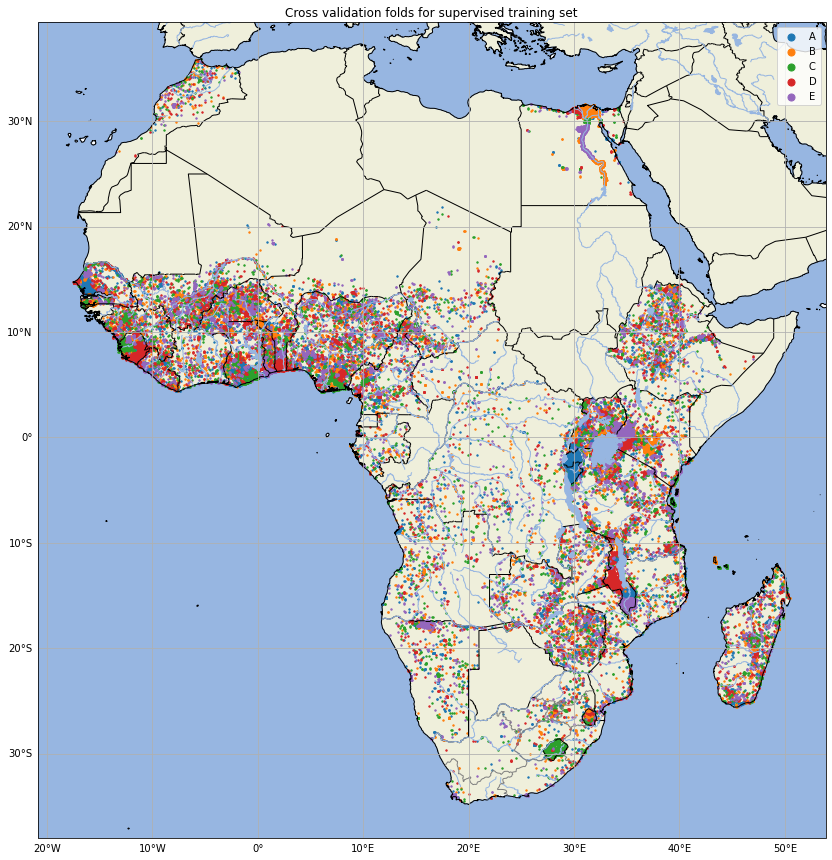

FOLD SIZES:
A :  11356
B :  11355
C :  11355
D :  11355
E :  11355


In [18]:
plot_splits({f: dhs_locs[new_dhs_incountry_folds[f]['test']] for f in FOLDS},
            title='Cross validation folds for supervised training set')
#plt.savefig('cv_folds.png', bbox_inches='tight')

print("FOLD SIZES:")
for fold in new_dhs_incountry_folds:
    print(fold, ": ", len(new_dhs_incountry_folds[fold]['test']))

In [6]:
import matplotlib.pyplot as plt
import seaborn as sns
FRACTION = 1
#fold_indices=dhs_incountry_folds['A']['test']

def plot_iwi_distribution(dhs_df, dhs_incountry_folds, plot_title='IWI distribution across folds'):

    #colors = ['steelblue', 'orange', 'green', 'red', 'purple']
    colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
    #color_pal = sns.color_palette("colorblind", 6).as_hex()
    #colors = ','.join(color_pal)
    #sns.set(rc={'figure.figsize':(22,10)})
    plt.figure(figsize=(20, 10), dpi=80)
    fig, axes=plt.subplots(1,1, figsize=(20,10))
    for i, fold in enumerate(['A', 'B', 'C', 'D', 'E']):
        x = dhs_df['iwi'].loc[dhs_incountry_folds[fold]['test']].values
        plt.axvline(x=np.mean(x), color=colors[i], alpha=0.4)
        ax=sns.kdeplot(data=x, color=colors[i])
        
        print("fold {} - MEAN: ".format(fold), np.mean(x), ", STD DEV: ", np.std(x))
    #sns.kdeplot(x=clusters_df_50_sample['iwi'], ax=ax)
    #sns.kdeplot(x=clusters_df_25_sample['iwi'], ax=ax)
    #sns.kdeplot(x=clusters_df_10_sample['iwi'], ax=ax)
    #sns.kdeplot(x=clusters_df_5_sample['iwi'], ax=ax)
    #sns.kdeplot(x=clusters_df_1_sample['iwi'], ax=ax)
    fig.legend(labels=['A', 'B', 'C', 'D', 'E'], prop={'size': 20})
    ax.yaxis.label.set_size(24)
    ax.xaxis.label.set_size(24)
    plt.xticks(fontsize=22, rotation=90)
    plt.yticks(fontsize=18, rotation=90)
    plt.xlabel('IWI')
    plt.ylabel('Density')
    #plt.title('IWI distribution of folds for {:.0f}% of labeled dataset'.format(FRACTION*100), fontsize=22)
    plt.title(plot_title, fontsize=22)

    plt.show()

#

fold A - MEAN:  27.481502641186253 , STD DEV:  17.475468811066367
fold B - MEAN:  37.63043378097127 , STD DEV:  20.47522197719095
fold C - MEAN:  34.21290825001402 , STD DEV:  20.271948048788932
fold D - MEAN:  30.31293311997825 , STD DEV:  18.918667182639147
fold E - MEAN:  30.85077883650291 , STD DEV:  18.134540420984873


<Figure size 1600x800 with 0 Axes>

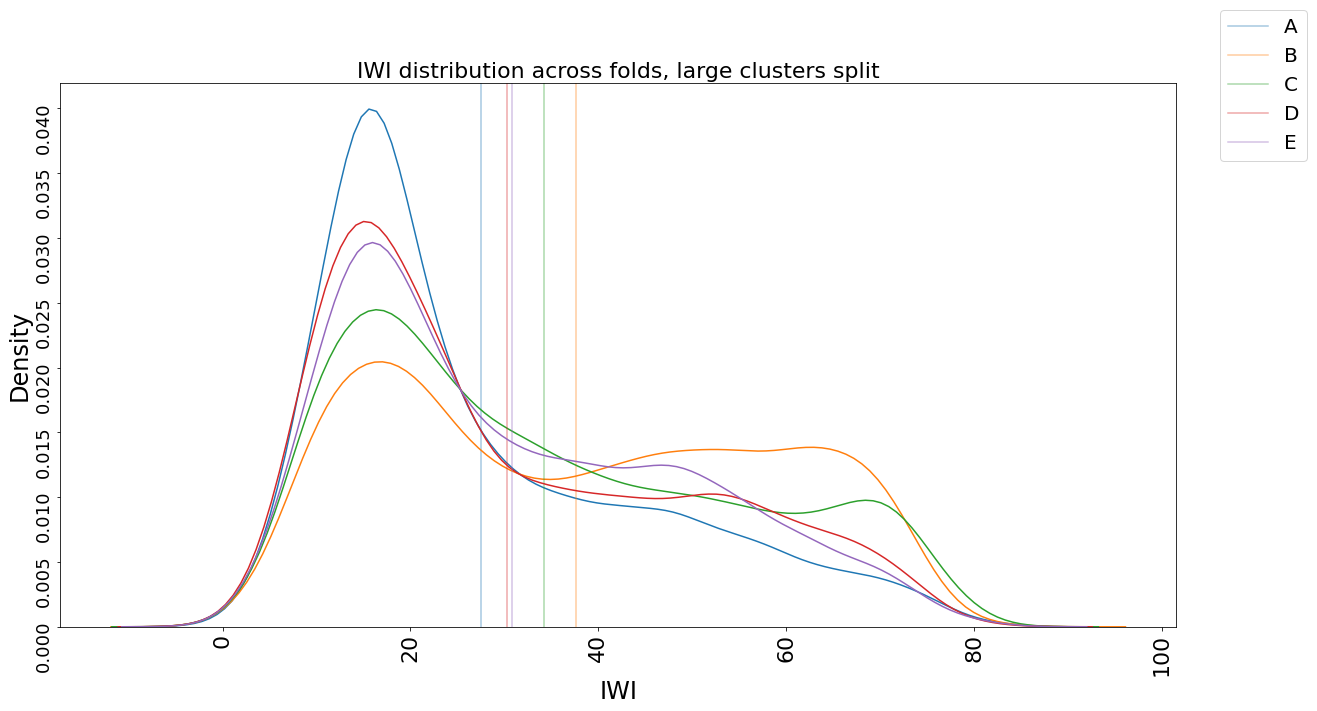

In [19]:
plot_iwi_distribution(dhs_df, new_dhs_incountry_folds, 'IWI distribution across folds, large clusters split')

In [92]:
preprocessing.create_folds_b.save_folds(
    folds_path='dhs_incountry_folds_0_25.pkl',
    folds=new_dhs_incountry_folds,
    check_exists=False)

In [50]:
print(f'Percentage removed: {100 * ((dhs_df.shape[0] - new_dhs_df.shape[0])/dhs_df.shape[0])}%')

Percentage removed: 0.7325815193635807%
